# Gerador de instâncias sintéticas para o problema de otimização do mestrado

### Etapas

**Geral**

1. Definir o grid

1. Definir bacias geológicas

1. Definir ...

1. Definir quantidade de projetos

**Para cada projeto:**

1. Escolher uma bacia

1. Sortear coordenada (x,y)

1. Pela bacia, temos a estratégia e a qualidade do dado

1. Dada a bacia, escoolher um play

1. O play vai indicar se é arenito ou carbonato, range de soterramento, e distribuição dos parâmetros volumétricos

1. O risco tem componentes regionais da bacia (geração), componentes do play (migração, retenção), e componentes individuais (geometria e reservatório).

1. A PCGNA é indicada pelo play

1. Simular volume geo, tec, ambos condicionais e incondicionais

1. O custo do poço exploratório depende da bacia, estratégia e soterramento

1. Cada bacia tem uma $f(vol) \rightarrow VPL$

1. Calcular distribuição de VPL e métricas de retorno (risco?)

1. Atribuir contratos à cada parte da bacia com OEs: simular leilões?

1. Tempo de excecução dos projetos é função do soterramento e estratégia

## Importando bibliotecas

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

%matplotlib inline

## Definição do grid

In [2]:
x_min, x_max = (0., 100.)
y_min, y_max = (0., 100.)
dx, dy = (1., 1.)
grid = np.zeros(( int((y_max-y_min)/dy), int((x_max-x_min)/dx) ))

In [3]:
grid.shape

(100, 100)

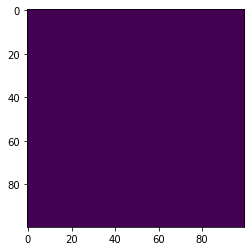

In [4]:
plt.imshow(grid)

## Criando bacias geológicas

In [5]:
estrategias = ['Estrutura pronta', 'Estrutura em construção', 'Nova fronteira']
qualidades_dado = ['Qualidade alta', 'Qualidade razoável', 'Qualidade baixa']

In [6]:
nx_bacias = 3
ny_bacias = 3
bacias = {}
count = 0
x_step = (x_max-x_min)/nx_bacias
y_step = (y_max-y_min)/ny_bacias
for i in range(1, ny_bacias+1):
    y_min_curr = (i-1)*y_step
    y_max_curr = (i)*y_step
    for j in range(1, nx_bacias+1):
        x_min_curr = (j-1)*x_step
        x_max_curr = j*x_step
        count += 1
        bacias["Bacia"+str(count)] = {}
        bacias["Bacia"+str(count)]['Coordenadas'] = ((x_min_curr, x_max_curr),(y_min_curr, y_max_curr))
        bacias["Bacia"+str(count)]['Maturidade'] = np.random.choice(estrategias)
        bacias["Bacia"+str(count)]['Qualidade do dado'] = np.random.choice(qualidades_dado)
        grid[int(x_min_curr):int(x_max_curr), int(y_min_curr):int(y_max_curr)] = count

In [7]:
bacias

{'Bacia1': {'Coordenadas': ((0.0, 33.333333333333336),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Nova fronteira',
  'Qualidade do dado': 'Qualidade razoável'},
 'Bacia2': {'Coordenadas': ((33.333333333333336, 66.66666666666667),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Estrutura pronta',
  'Qualidade do dado': 'Qualidade baixa'},
 'Bacia3': {'Coordenadas': ((66.66666666666667, 100.0),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Estrutura em construção',
  'Qualidade do dado': 'Qualidade baixa'},
 'Bacia4': {'Coordenadas': ((0.0, 33.333333333333336),
   (33.333333333333336, 66.66666666666667)),
  'Maturidade': 'Estrutura em construção',
  'Qualidade do dado': 'Qualidade razoável'},
 'Bacia5': {'Coordenadas': ((33.333333333333336, 66.66666666666667),
   (33.333333333333336, 66.66666666666667)),
  'Maturidade': 'Estrutura em construção',
  'Qualidade do dado': 'Qualidade razoável'},
 'Bacia6': {'Coordenadas': ((66.66666666666667, 100.0),
   (33.333333333333336, 66.6666666

In [8]:
colormap_dict = cm.cmap_d.keys()
colormap_dict

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

In [9]:
colormap = cm.inferno

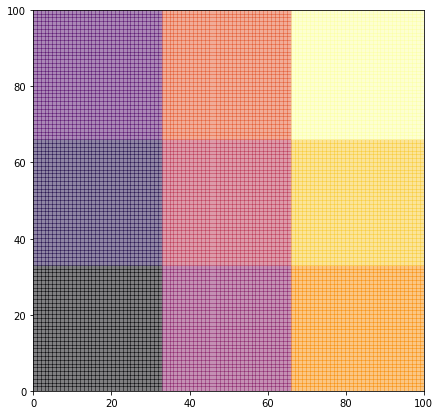

In [10]:
plt.figure(figsize=(7, 7))
plt.pcolormesh(grid, alpha=0.5, cmap=colormap)

## Criando projetos

In [11]:
n_plays = 10
plays = ['Play '+str(i) for i in range(1, n_plays+1)]

In [12]:
n_projetos = 300
projetos = {}
projetos['Coordenada x'] = []
projetos['Coordenada y'] = []
projetos['Bacia'] = []
projetos['Nome'] = []
projetos['Maturidade bacia'] = []
projetos['Qualidade do dado'] = []
projetos['Play'] = []

for i in range(n_projetos):
    
    # primeiro, sortear uma bacia
    bacia = np.random.choice(list(bacias.keys()))
    
    # não permitir coordenadas nas bordas das bacias
    fator = 0.8
    x_min_curr, x_max_curr = bacias[bacia]['Coordenadas'][0]
    y_min_curr, y_max_curr = bacias[bacia]['Coordenadas'][1]
    
    x_proj, y_proj = (np.random.uniform(x_min_curr + x_step*(1-fator), x_max_curr - x_step*(1-fator)), 
                      np.random.uniform(y_min_curr + y_step*(1-fator), y_max_curr - y_step*(1-fator)))
    
    projetos['Nome'].append("Projeto " + str(i+1))
    projetos['Bacia'].append(bacia)
    projetos['Coordenada x'].append(x_proj)
    projetos['Coordenada y'].append(y_proj)
    projetos['Maturidade bacia'].append(bacias[bacia]['Maturidade'])
    projetos['Qualidade do dado'].append(bacias[bacia]['Qualidade do dado'])
    projetos['Play'].append(np.random.choice(plays))

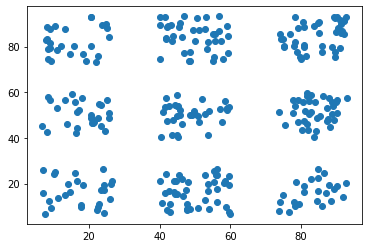

In [13]:
plt.scatter(projetos['Coordenada x'], projetos['Coordenada y'])

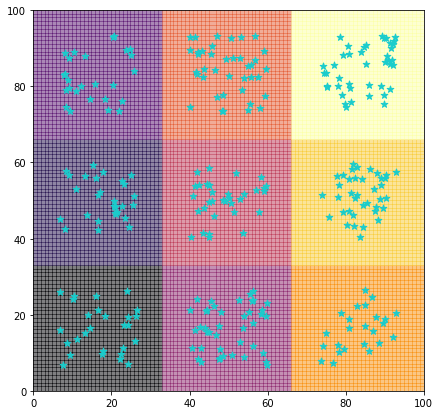

In [14]:
fig = plt.figure(figsize=(7, 7), frameon=False)

im1 = plt.pcolormesh(grid, alpha=0.5, cmap=colormap)
im2 = plt.scatter(projetos['Coordenada x'], projetos['Coordenada y'], color=(0.1, 0.8, 0.8), s=50, marker='*')

plt.show()

In [15]:
proj_df = pd.DataFrame(projetos)

In [16]:
proj_df

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play
0,88.883448,80.055862,Bacia9,Projeto 1,Nova fronteira,Qualidade razoável,Play 2
1,16.572381,44.580512,Bacia4,Projeto 2,Estrutura em construção,Qualidade razoável,Play 2
2,78.247171,10.243562,Bacia3,Projeto 3,Estrutura em construção,Qualidade baixa,Play 8
3,40.155509,74.558282,Bacia8,Projeto 4,Estrutura pronta,Qualidade alta,Play 8
4,6.726483,45.119771,Bacia4,Projeto 5,Estrutura em construção,Qualidade razoável,Play 8
...,...,...,...,...,...,...,...
295,87.712580,48.251175,Bacia6,Projeto 296,Estrutura pronta,Qualidade baixa,Play 2
296,89.024217,54.001200,Bacia6,Projeto 297,Estrutura pronta,Qualidade baixa,Play 10
297,81.974275,43.439030,Bacia6,Projeto 298,Estrutura pronta,Qualidade baixa,Play 5
298,91.735194,87.009178,Bacia9,Projeto 299,Nova fronteira,Qualidade razoável,Play 8


In [17]:
proj_df['Bacia'].unique(), proj_df['Maturidade bacia'].unique(), proj_df['Qualidade do dado'].unique(), proj_df['Play'].unique()

(array(['Bacia9', 'Bacia4', 'Bacia3', 'Bacia8', 'Bacia5', 'Bacia2',
        'Bacia1', 'Bacia7', 'Bacia6'], dtype=object),
 array(['Nova fronteira', 'Estrutura em construção', 'Estrutura pronta'],
       dtype=object),
 array(['Qualidade razoável', 'Qualidade baixa', 'Qualidade alta'],
       dtype=object),
 array(['Play 2', 'Play 8', 'Play 4', 'Play 5', 'Play 3', 'Play 10',
        'Play 1', 'Play 6', 'Play 9', 'Play 7'], dtype=object))

## Soterramento, parâmetros volumétricos e risco

In [18]:
incerteza_p10p90 = {'Qualidade alta': 2,
                    'Qualidade razoável': 3,
                    'Qualidade baixa': 4}

In [19]:
soterramento_range = (1000., 5000.)

pcgna_range = (0., 1.)

area_range = (20., 200.)
netpay_range = (5., 100.)
phi_range = (0.10, 0.32)
trapfill_range = (0.5, 1.)
shc_range = (0.5, 1.)
bo_range = (1.4, 1.9)
bg_range = (0.002, 0.004)
rgo_range = (150, 250)
rlg_range = (0.1, 0.15)
froleo_range = (0.15, 0.25)
frga_range = (0.15, 0.25)
frgna_range = (0.15, 0.25)

In [20]:
plays_completo = {}
for p in plays:
    plays_completo[copy.copy(p)] = {}
    
    plays_completo[copy.copy(p)]['Soterramento'] = np.random.uniform(soterramento_range[0], soterramento_range[1], 2)
    plays_completo[copy.copy(p)]['pcgna'] = np.random.uniform(pcgna_range[0], pcgna_range[1], 2)
    plays_completo[copy.copy(p)]['area'] = np.random.uniform(area_range[0], area_range[1], 2)
    plays_completo[copy.copy(p)]['netpay'] = np.random.uniform(netpay_range[0], netpay_range[1], 2)
    plays_completo[copy.copy(p)]['phi'] = np.random.uniform(phi_range[0], phi_range[1], 2)
    plays_completo[copy.copy(p)]['trapfill'] = np.random.uniform(trapfill_range[0], trapfill_range[1], 2)
    plays_completo[copy.copy(p)]['shc'] = np.random.uniform(shc_range[0], shc_range[1], 2)
    plays_completo[copy.copy(p)]['bo'] = np.random.uniform(bo_range[0], bo_range[1], 2)
    plays_completo[copy.copy(p)]['bg'] = np.random.uniform(bg_range[0], bg_range[1], 2)
    plays_completo[copy.copy(p)]['rgo'] = np.random.uniform(rgo_range[0], rgo_range[1], 2)
    plays_completo[copy.copy(p)]['rlg'] = np.random.uniform(rlg_range[0], rlg_range[1], 2)
    plays_completo[copy.copy(p)]['froleo'] = np.random.uniform(froleo_range[0], froleo_range[1], 2)
    plays_completo[copy.copy(p)]['frga'] = np.random.uniform(frga_range[0], frga_range[1], 2)
    plays_completo[copy.copy(p)]['frgna'] = np.random.uniform(frgna_range[0], frgna_range[1], 2)

In [21]:
plays_completo

{'Play 1': {'Soterramento': array([1957.18377218, 1010.76506525]),
  'pcgna': array([0.73327504, 0.10092399]),
  'area': array([30.56061712, 95.26312757]),
  'netpay': array([80.0022551 , 76.98606753]),
  'phi': array([0.27151427, 0.27775797]),
  'trapfill': array([0.68046387, 0.88403413]),
  'shc': array([0.73418783, 0.91920694]),
  'bo': array([1.49168945, 1.62638006]),
  'bg': array([0.00262653, 0.00329918]),
  'rgo': array([209.23162449, 218.82442522]),
  'rlg': array([0.12898997, 0.12623256]),
  'froleo': array([0.20904303, 0.18531627]),
  'frga': array([0.20908722, 0.18679546]),
  'frgna': array([0.16353729, 0.15133236])},
 'Play 2': {'Soterramento': array([1436.07096567, 2978.78274065]),
  'pcgna': array([0.9333308 , 0.22605561]),
  'area': array([ 29.30498702, 160.84658727]),
  'netpay': array([50.61169046, 18.39992394]),
  'phi': array([0.30780172, 0.19837865]),
  'trapfill': array([0.85880501, 0.90569023]),
  'shc': array([0.91364738, 0.95659907]),
  'bo': array([1.62558643, 